In [1]:
# Import the necessary libraries
import pandas as pd
import json
import string
import unicodedata
import re
import itertools
import nltk

from collections import Counter
from collections import OrderedDict 
from tqdm import tqdm
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline

In [2]:
# Set the location of various files which would be used for the processing
path2files="data/yelp_dataset_challenge_academic_dataset/"
path2buisness=path2files+"yelp_academic_dataset_business.json"
path2reviews=path2files+"yelp_academic_dataset_review.json"

path2indiandish='Indian_corrected.label'

In [3]:
# find all the Indian restaurants
business_id = []
restaurant_name = dict()
cuisine = 'Indian'

with open (path2buisness, 'r', encoding='utf-8') as f:
    for line in f.readlines():
        business_json = json.loads(line)
        
        if cuisine in business_json['categories']:
            data_id = business_json['business_id']
            business_id.append(data_id)
            restaurant_name[data_id] = business_json['name']

In [4]:
%%time
# extract the reviews
reviews = [] 
stars = []
rest_name = []

with open (path2reviews, 'r', encoding='utf-8') as f:
    for line in f.readlines():
        review_json = json.loads(line)
        if review_json['business_id'] in business_id:
            reviews.append(review_json['text'])
            stars.append(review_json['stars'])
            rest_name.append(restaurant_name[review_json['business_id']])
print(len(reviews), len(stars), len(rest_name))

8230 8230 8230
Wall time: 14 s


In [5]:
# List of dish having value as 1 (Indian Dish);
dish_list = []
with open(path2indiandish, 'r') as rf:
    for line in rf:
        #split_list = line.strip().split()
        if line.strip().split("\t")[1] == "1":
            dish_list.append(line.strip().split("\t")[0])
        
print(len(dish_list))
dish_list


16


['chick peas',
 'chicken tikka',
 'flat bread',
 'tandoori chicken',
 'rogan josh',
 'gulab jamun',
 'basmati rice',
 'rice pudding',
 'fried rice',
 'ice cream',
 'tomato soup',
 'chicken tikka masala',
 'tomato sauce',
 'the naan was',
 'tikka masala',
 'coconut chicken']

In [6]:
# ******************** 4a. Popularity By Dish Mention Count **********************
dish_counter = dict(zip(dish_list, [0]*len(dish_list)))
for dish in dish_list:
    for review in reviews:
        review = review.replace("\t", " ")\
                      .replace("\n", "")\
                      .replace("\r", "")\
                      .lower().strip()
        dish_counter[dish] += review.count(dish)

In [7]:
N = 16
sorted_dish_counter = {k: v for k, v in sorted(dish_counter.items(), key=lambda item: item[1], reverse=True)}
topN = dict(itertools.islice(sorted_dish_counter.items(), N))
dish_count_df = pd.DataFrame(topN.items(), columns=["Dish_Name", "Count"])

In [8]:
topN

{'tikka masala': 1107,
 'chicken tikka': 1054,
 'chicken tikka masala': 787,
 'tandoori chicken': 527,
 'basmati rice': 249,
 'the naan was': 236,
 'rice pudding': 189,
 'gulab jamun': 155,
 'ice cream': 97,
 'rogan josh': 77,
 'tomato soup': 35,
 'fried rice': 34,
 'chick peas': 31,
 'flat bread': 30,
 'tomato sauce': 27,
 'coconut chicken': 14}

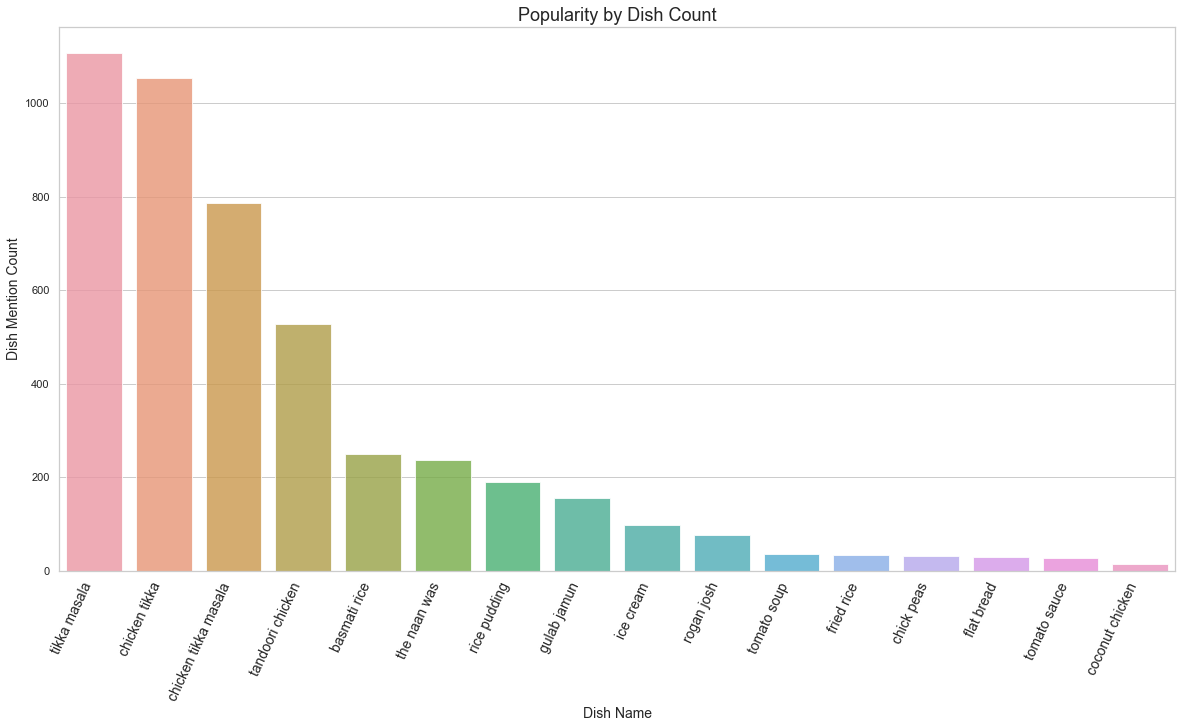

In [9]:
# bar plot using seaborn library
plt.figure(figsize=(20,10))
snsDish = sns.barplot(x="Dish_Name", y="Count", data=dish_count_df, alpha=0.8)
snsDish.set_xticklabels(snsDish.get_xmajorticklabels(), fontsize = 14)
plt.xticks(rotation=65, horizontalalignment='right')
plt.title('Popularity by Dish Count', fontsize=18)
plt.xlabel('Dish Name', fontsize=14)
plt.ylabel('Dish Mention Count', fontsize=14)
plt.show()

In [10]:
# ******************** 4b. Popularity by Number of Retaurants **********************
unique_restaurants = list(set(rest_name))
dish_rest_counter = dict(zip(dish_list, [0]*len(dish_list)))

for dish in dish_list:
    # for each dish, keep track of the unique restaurants that mention the particular dish
    restaurant_tracker = dict(zip(unique_restaurants, [0]*len(unique_restaurants)))
    for i, review in enumerate(reviews):
        review = review.replace("\t", " ")\
                      .replace("\n", "")\
                      .replace("\r", "")\
                      .lower().strip()

        if dish in review:
            restaurant_tracker[rest_name[i]] = 1
    dish_rest_counter[dish] += sum(restaurant_tracker.values())

In [11]:
N = 16
sorted_dish_counter = {k: v for k, v in sorted(dish_rest_counter.items(), key=lambda item: item[1], reverse=True)}
topN = dict(itertools.islice(sorted_dish_counter.items(), N))
dish_count_df2 = pd.DataFrame(topN.items(), columns=["Dish_Name", "Count"])

In [12]:
topN

{'chicken tikka': 112,
 'tikka masala': 106,
 'chicken tikka masala': 101,
 'tandoori chicken': 84,
 'the naan was': 71,
 'basmati rice': 64,
 'gulab jamun': 57,
 'rice pudding': 51,
 'ice cream': 44,
 'rogan josh': 33,
 'chick peas': 20,
 'tomato sauce': 18,
 'fried rice': 17,
 'flat bread': 16,
 'tomato soup': 15,
 'coconut chicken': 9}

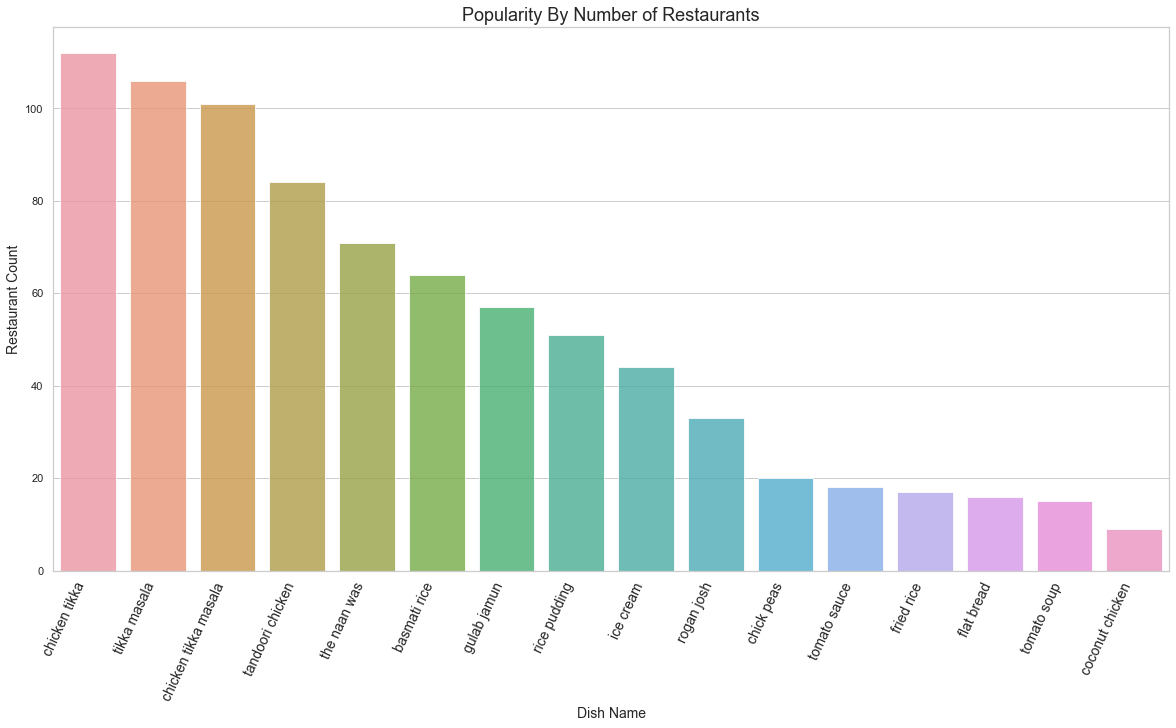

In [13]:
# Bar plot using Seaborn library
plt.figure(figsize=(20,10))
snsRest = sns.barplot(x="Dish_Name", y="Count", data=dish_count_df2, alpha=0.8)
snsRest.set_xticklabels(snsRest.get_xmajorticklabels(), fontsize = 14)
plt.xticks(rotation=65, horizontalalignment='right')
plt.title('Popularity By Number of Restaurants', fontsize=18)
plt.xlabel('Dish Name', fontsize=14)
plt.ylabel('Restaurant Count', fontsize=14)
plt.show()

In [14]:
# ******************** 4c. Popularity By Average Rating **********************
# initialize dataframe
dish_rating_df = pd.DataFrame(columns=['Dish_Name', 'Total_Rating', "Review_Count"])
dish_rating_df['Dish_Name'] = dish_list
dish_rating_df['Total_Rating'] = [0]*len(dish_list)
dish_rating_df['Review_Count'] = [0]*len(dish_list)

for i, dish in enumerate(dish_list):
    for j, review in enumerate(reviews):
        if stars[j] == 3: # skip "neutral" reviews by stars
            continue
        review = review.replace("\t", " ")\
                      .replace("\n", "")\
                      .replace("\r", "")\
                      .lower().strip()
        if dish in review:
            dish_rating_df.loc[i, 'Review_Count'] += 1 # used for average
            dish_rating_df.loc[i, 'Total_Rating'] += stars[j]

# compute average rating
dish_rating_df['Average_Rating'] = dish_rating_df['Total_Rating'] / dish_rating_df['Review_Count']

In [15]:
# Use # of reviews as tiebreaker if needed
dish_rating_df = dish_rating_df.sort_values(by=['Average_Rating', 'Review_Count'], axis=0, ascending=False)

In [16]:
dish_rating_df

,Dish_Name,Total_Rating,Review_Count,Average_Rating
9,ice cream,306,71,4.309859
4,rogan josh,266,63,4.222222
7,rice pudding,580,138,4.202899
2,flat bread,113,27,4.185185
0,chick peas,99,24,4.125000
15,coconut chicken,53,13,4.076923
6,basmati rice,780,192,4.062500
5,gulab jamun,433,107,4.046729
1,chicken tikka,3044,757,4.021136
14,tikka masala,3090,774,3.992248


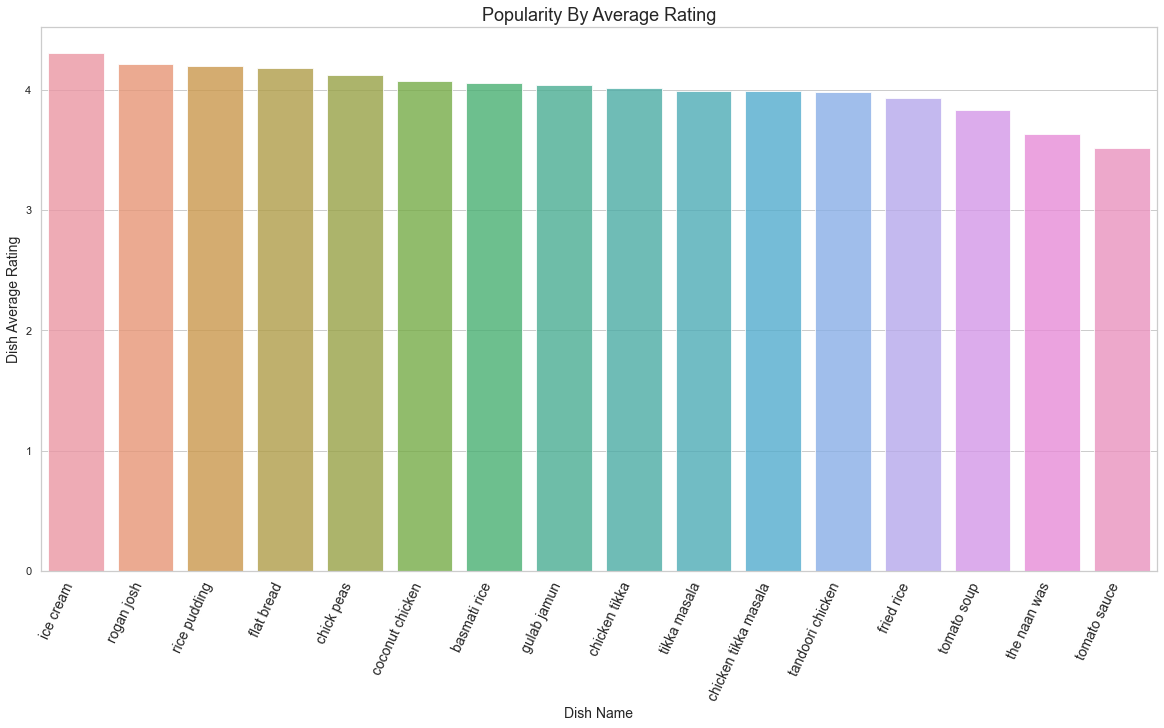

In [17]:
# bar plot using seborn library
plt.figure(figsize=(20,10))
snsRate = sns.barplot(x="Dish_Name", y="Average_Rating", data=dish_rating_df, alpha=0.8)
snsRate.set_xticklabels(snsRate.get_xmajorticklabels(), fontsize = 14)
plt.xticks(rotation=65, horizontalalignment='right')
plt.title('Popularity By Average Rating', fontsize=18)
plt.xlabel('Dish Name', fontsize=14)
plt.ylabel('Dish Average Rating', fontsize=14)
plt.show()

In [18]:
%%time
# ******************** 4d. Popularity By Sentiment **********************
# initialize dataframe
dish_sentiment_df = pd.DataFrame(columns=['Dish_Name', 'Total_Sentiment', "Review_Count"])
dish_sentiment_df['Dish_Name'] = dish_list
dish_sentiment_df['Total_Sentiment'] = [0]*len(dish_list)
dish_sentiment_df['Review_Count'] = [0]*len(dish_list)

for i, dish in enumerate(dish_list):
    for j, review in enumerate(reviews):
        if stars[j] == 3: # skip neutral reviews by stars
            continue
        review = review.replace("\t", " ")\
                      .replace("\n", "")\
                      .replace("\r", "")\
                      .lower().strip()
        if dish in review:
            toAnalyze = TextBlob(review)               # sentiment analysis part
            sent = toAnalyze.sentiment.polarity
            scaled_sent = 5*(sent+1)                   # Affine transformation
            dish_sentiment_df.loc[i, 'Review_Count'] += 1 # used for average
            dish_sentiment_df.loc[i, 'Total_Sentiment'] += scaled_sent

        # compute average rating
dish_sentiment_df['Average_Sentiment'] = dish_sentiment_df['Total_Sentiment'] / dish_rating_df['Review_Count']

Wall time: 8.91 s


In [19]:
# Sort and use # of reviews as tiebreaker if needed
dish_sentiment_df = dish_sentiment_df.sort_values(by=['Average_Sentiment', 'Review_Count'], axis=0, ascending=False)

In [20]:
dish_sentiment_df

,Dish_Name,Total_Sentiment,Review_Count,Average_Sentiment
9,ice cream,443.137333,71,6.241371
4,rogan josh,391.553266,63,6.215131
0,chick peas,148.963267,24,6.206803
7,rice pudding,841.087350,138,6.094836
8,fried rice,175.777196,29,6.061283
5,gulab jamun,644.656903,107,6.024831
13,the naan was,1066.244065,177,6.023978
2,flat bread,162.011648,27,6.000431
6,basmati rice,1151.388764,192,5.996816
10,tomato soup,143.594210,24,5.983092


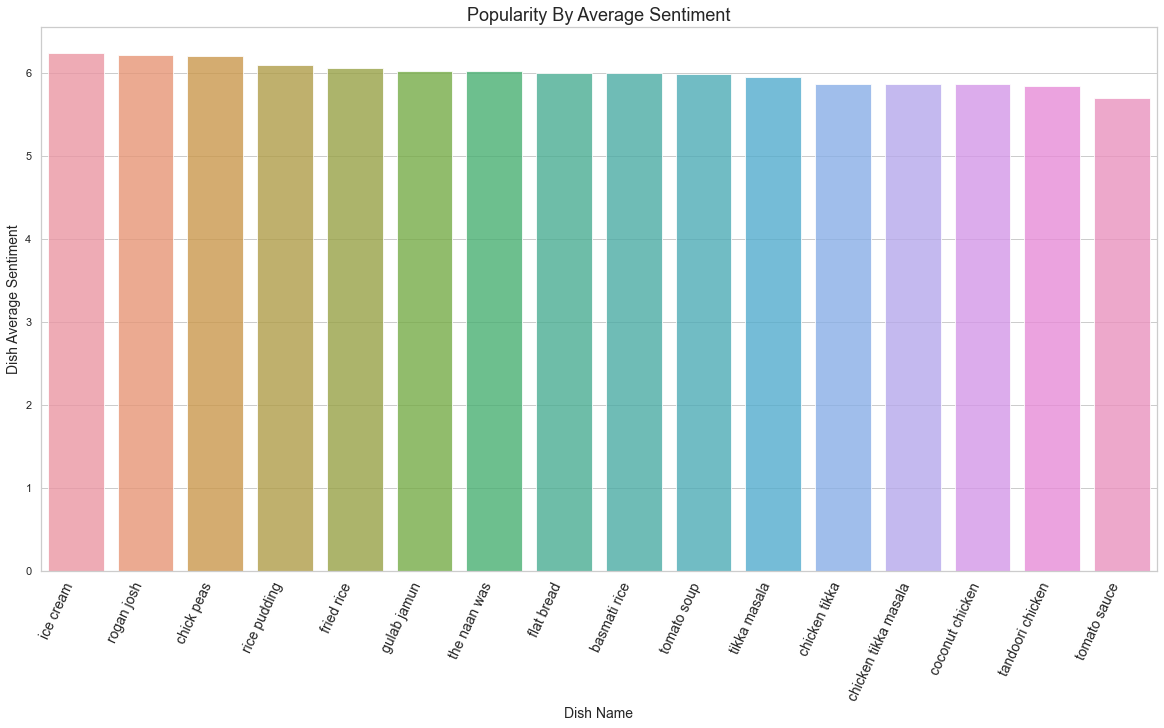

In [21]:
# Bar plot using seaborn library
plt.figure(figsize=(20,10))
snsSent = sns.barplot(x="Dish_Name", y="Average_Sentiment", data=dish_sentiment_df, alpha=0.8)
snsSent.set_xticklabels(snsSent.get_xmajorticklabels(), fontsize = 14)
plt.xticks(rotation=65, horizontalalignment='right')
plt.title('Popularity By Average Sentiment', fontsize=18)
plt.xlabel('Dish Name', fontsize=14)
plt.ylabel('Dish Average Sentiment', fontsize=14)
plt.show()

In [22]:
# Comparision of popularity of dishes based on different parameters
# A_dish_count: Popularity By Dish Count
# B_restaurant_count: Popularity by Number of Restaurants
# C_avg_rating: Popularity By Average Rating
# D_avg_sentiment: Popularity By Sentiment

colA = list(dish_count_df['Dish_Name'])
colB = list(dish_count_df2['Dish_Name'])
colC = list(dish_rating_df['Dish_Name'])
colD = list(dish_sentiment_df['Dish_Name'])
colRank = list(range(1,len(dish_list)+1))

combined_dict = {'rank':colRank,
                'A_dish_count':colA, 
                'B_restaurant_count':colB,
                'C_avg_rating':colC,
                'D_avg_sentiment':colD}

comparison_df = pd.DataFrame(combined_dict)
comparison_df

,rank,A_dish_count,B_restaurant_count,C_avg_rating,D_avg_sentiment
0,1,tikka masala,chicken tikka,ice cream,ice cream
1,2,chicken tikka,tikka masala,rogan josh,rogan josh
2,3,chicken tikka masala,chicken tikka masala,rice pudding,chick peas
3,4,tandoori chicken,tandoori chicken,flat bread,rice pudding
4,5,basmati rice,the naan was,chick peas,fried rice
5,6,the naan was,basmati rice,coconut chicken,gulab jamun
6,7,rice pudding,gulab jamun,basmati rice,the naan was
7,8,gulab jamun,rice pudding,gulab jamun,flat bread
8,9,ice cream,ice cream,chicken tikka,basmati rice
9,10,rogan josh,rogan josh,tikka masala,tomato soup


In [23]:
# ******************** 5a. Recommendation By Average Rating **********************
selected_dishes = ['chicken tikka', 'chicken tikka masala', 'tikka masala']
unique_restaurants = list(set(rest_name))
rest_total_rating = OrderedDict(zip(unique_restaurants, [0]*len(unique_restaurants)))
rest_review_counter = OrderedDict(zip(unique_restaurants, [0]*len(unique_restaurants)))

for i, review in enumerate(reviews):
    review = review.replace("\t", " ").replace("\n", "").replace("\r", "").lower().strip()

    if (selected_dishes[0] in review) or (selected_dishes[1] in review) or (selected_dishes[2] in review):
        rest_review_counter[rest_name[i]] += 1 # used for average
        rest_total_rating[rest_name[i]] += stars[i]
    

In [24]:
rest_rating_df = pd.DataFrame(columns=['Restaurant_Name', 'Total_Rating', "Review_Count"])
rest_rating_df['Restaurant_Name'] = list(rest_total_rating.keys())
rest_rating_df['Total_Rating'] = list(rest_total_rating.values())
rest_rating_df['Review_Count'] = list(rest_review_counter.values())
rest_rating_df['Average_Rating'] = (rest_rating_df['Total_Rating'] + 1e-3)/ (rest_rating_df['Review_Count'] + 1e-3)

In [25]:
# sort restaurants by average rating and use # of reviews as tiebreaker if needed
# drop restaurants with fewer than a predetermined minimum threshold of reviews
# select the top 10 (as Yelp often displays the results)
rest_rating_df = rest_rating_df.sort_values(by=['Average_Rating', 'Review_Count'], axis=0, ascending=False)\
                               .reset_index(drop=True)
# display(rest_rating_df.head(25))
top10_A = rest_rating_df[rest_rating_df['Review_Count'] >= 5].head(10)
top10_A

,Restaurant_Name,Total_Rating,Review_Count,Average_Rating
11,Kebab Mahal,33,7,4.713755
14,Flavor of India,23,5,4.599280
15,Mount Everest India's Cuisine,181,40,4.524912
17,Star of India,66,15,4.399773
18,OM Restaurant,44,10,4.399660
19,India Garden,26,6,4.332778
20,Delhi Indian Cuisine,26,6,4.332778
22,Dhaba Indian Bistro,60,14,4.285480
23,Swad,30,7,4.285245
24,Maharaja Restaurant,47,11,4.272430


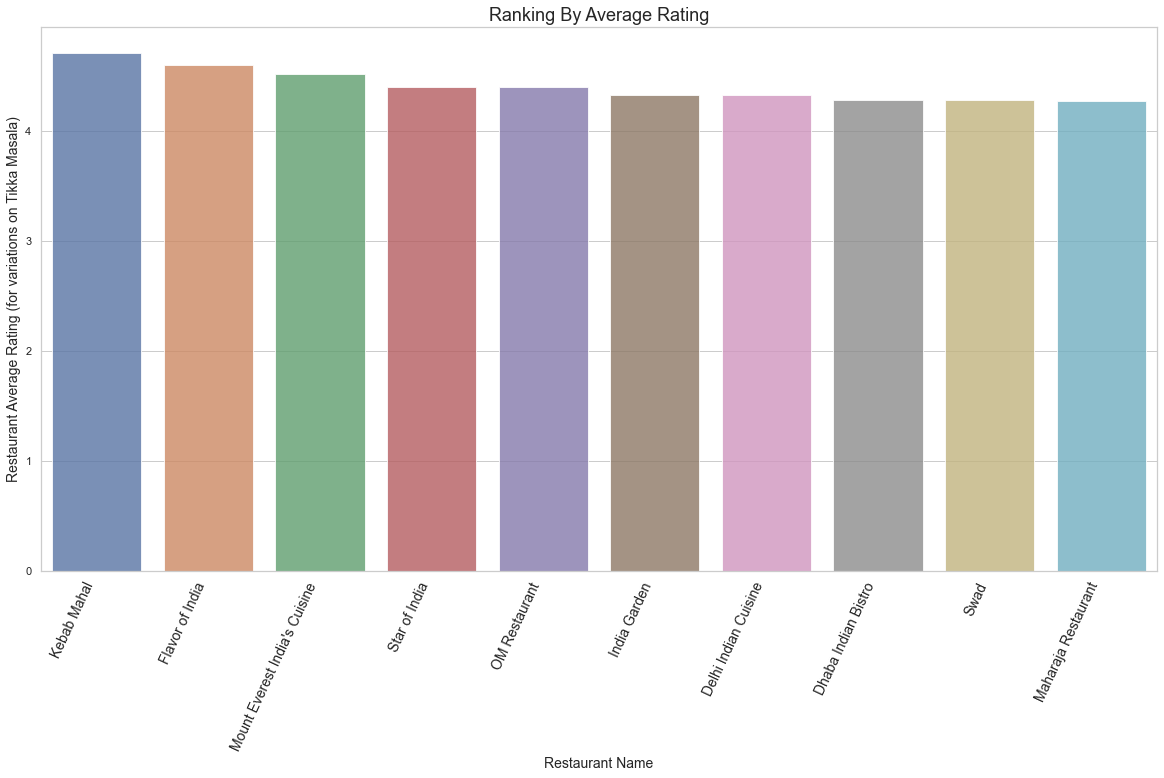

In [26]:
# Bar plot using seaborn library
plt.figure(figsize=(20,10))
snsRestAvg = sns.barplot(x="Restaurant_Name", y="Average_Rating", data=top10_A, alpha=0.8)
snsRestAvg.set_xticklabels(snsRestAvg.get_xmajorticklabels(), fontsize = 14)
plt.xticks(rotation=65, horizontalalignment='right')
plt.title('Ranking By Average Rating', fontsize=18)
plt.xlabel('Restaurant Name', fontsize=14)
plt.ylabel('Restaurant Average Rating (for variations on Tikka Masala)', fontsize=14)
plt.show()

In [27]:
# ******************** 5b. Recommendation By Average Sentiment **********************
unique_restaurants = list(set(rest_name))
rest_total_sentiment = OrderedDict(zip(unique_restaurants, [0]*len(unique_restaurants)))
rest_review_counter = OrderedDict(zip(unique_restaurants, [0]*len(unique_restaurants)))

for i, review in enumerate(reviews):
    review = review.replace("\t", " ").replace("\n", "").replace("\r", "").lower().strip()
    # skip "neutral" reviews by stars
    if stars[i] == 3:
        continue
    if (selected_dishes[0] in review) or (selected_dishes[1] in review) or (selected_dishes[2] in review):
        toAnalyze = TextBlob(review)               # sentiment analysis part
        sent = toAnalyze.sentiment.polarity
        scaled_sent = 5*(sent+1)
        rest_review_counter[rest_name[i]] += 1 # used for average
        rest_total_sentiment[rest_name[i]] += scaled_sent
    

In [28]:
rest_sentiment_df = pd.DataFrame(columns=['Restaurant_Name', 'Total_Sentiment', "Review_Count"])
rest_sentiment_df['Restaurant_Name'] = list(rest_total_sentiment.keys())
rest_sentiment_df['Total_Sentiment'] = list(rest_total_sentiment.values())
rest_sentiment_df['Review_Count'] = list(rest_review_counter.values())
rest_sentiment_df['Average_Sentiment'] = (rest_sentiment_df['Total_Sentiment'] + 1e-3)/ (rest_sentiment_df['Review_Count'] + 1e-3)

In [29]:
# sort restaurants by average sentiment and use # of reviews as tiebreaker if needed
# drop restaurants with fewer than a predetermined minimum threshold of reviews
# select the top 10 (as Yelp often displays the results)
rest_sentiment_df = rest_sentiment_df.sort_values(by=['Average_Sentiment', 'Review_Count'], axis=0, ascending=False)\
                                     .reset_index(drop=True)
#display(rest_sentiment_df.head(25))
top10_B = rest_sentiment_df[rest_sentiment_df['Review_Count'] >= 5].head(10)
top10_B

,Restaurant_Name,Total_Sentiment,Review_Count,Average_Sentiment
2,Swad,34.477845,5,6.894390
5,Kebab Mahal,47.067544,7,6.723117
8,India Garden,32.851655,5,6.569217
14,Maharaja Restaurant E Pt Plaza,31.364668,5,6.271879
15,Copper Kettle,43.813030,7,6.258253
18,Taj Palace,198.983718,32,6.218078
19,Tandoori Times 3 Indian Bistro,74.617617,12,6.217700
20,Samosa Factory,111.179494,18,6.176351
21,OM Restaurant,55.575237,9,6.174451
22,Delhi Indian Cuisine,36.995961,6,6.165133


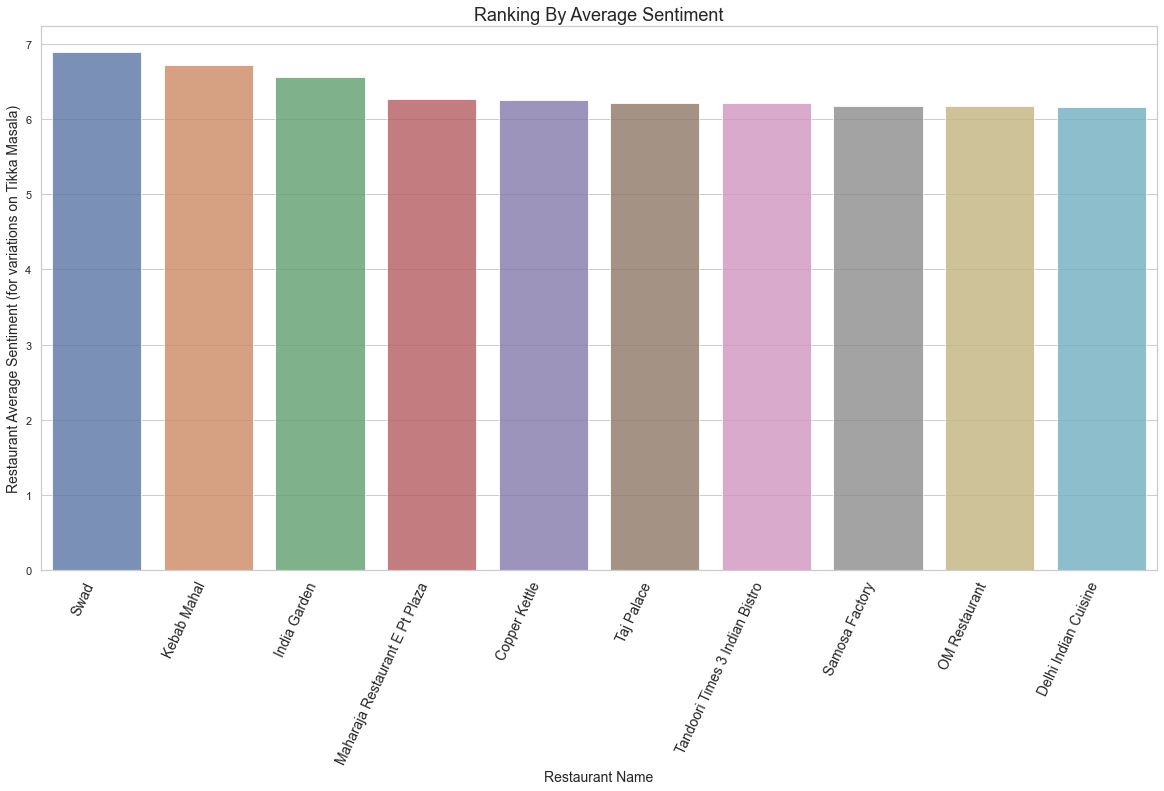

In [30]:
# bar plot using seaborn library
plt.figure(figsize=(20,10))
snsRestSent = sns.barplot(x="Restaurant_Name", y="Average_Sentiment", data=top10_B, alpha=0.8)
snsRestSent.set_xticklabels(snsRestSent.get_xmajorticklabels(), fontsize = 14)
plt.xticks(rotation=65, horizontalalignment='right')
plt.title('Ranking By Average Sentiment', fontsize=18)
plt.xlabel('Restaurant Name', fontsize=14)
plt.ylabel('Restaurant Average Sentiment (for variations on Tikka Masala)', fontsize=14)
plt.show()

In [31]:
# Comparision of recommendations of restaurants
colA = list(top10_A['Restaurant_Name'])
colB = list(top10_B['Restaurant_Name'])
colRank = list(range(1,11))

combined_dict = {'rank':colRank,
                'A_avg_rating':colA, 
                'B_avg_sentiment':colB}

comparison_df = pd.DataFrame(combined_dict)
comparison_df

,rank,A_avg_rating,B_avg_sentiment
0,1,Kebab Mahal,Swad
1,2,Flavor of India,Kebab Mahal
2,3,Mount Everest India's Cuisine,India Garden
3,4,Star of India,Maharaja Restaurant E Pt Plaza
4,5,OM Restaurant,Copper Kettle
5,6,India Garden,Taj Palace
6,7,Delhi Indian Cuisine,Tandoori Times 3 Indian Bistro
7,8,Dhaba Indian Bistro,Samosa Factory
8,9,Swad,OM Restaurant
9,10,Maharaja Restaurant,Delhi Indian Cuisine
